# K-Nearest Neighbors (KNN) - No-Framework Implementation

Multi-class classification on the **Covertype (Forest Cover Type)** dataset using pure NumPy.

**Dataset**: 581,012 samples, 54 features, 7 forest cover types  
**Task**: Predict forest cover type from cartographic variables  
**Key Concept**: KNN is a "lazy learner" - no training phase, expensive at prediction time

## What We'll Build From Scratch
- **Euclidean/Manhattan distance** calculation (vectorized)
- **K-nearest neighbor search** using argsort
- **Majority voting** for multi-class prediction
- **Batched prediction** to handle 464K training samples without OOM
- **Distance-weighted voting** (optional advanced feature)


In [1]:
# Standard libraries
import numpy as np
import sys

# Add utils to path
sys.path.append('../..')
from utils.data_loader import load_processed_data
from utils.metrics import accuracy, macro_f1_score, confusion_matrix_multiclass
from utils.visualization import (
    plot_confusion_matrix_multiclass,
    plot_validation_curve,
    plot_per_class_f1
)
from utils.performance import track_performance

print("Imports complete!")

Imports complete!


In [2]:
# Load Preprocessed data
"""
Data was preprocessed in data-preperation/preprocess_knn.py
    - 80/20 split
    - StandardScaler applied (fit on train only)
    - All 4 frameworks load identical data for fair comparison
"""

X_train, X_test, y_train, y_test, metadata = load_processed_data('knn')

# Extract metadata for reference
class_names = metadata['class_names']
n_classes = metadata['n_classes']

print(f"Training set: {X_train.shape[0]:,} samples, {X_train.shape[1]} features")
print(f"Test set: {X_test.shape[0]:,} samples")
print(f"Classes ({n_classes}): {class_names}")

Training set: 464,809 samples, 54 features
Test set: 116,203 samples
Classes (7): ['Spruce/Fir', 'Lodgepole Pine', 'Ponderosa Pine', 'Cottonwood/Willow', 'Aspen', 'Douglas-fir', 'Krummholz']


## Manhattan Distance Function

- Scikit-Learn found that **Manhattan distance** (L1) outperforms Euclidean (L2) for this dataset.
- We'll implement Manhattan distance from scratch.

**Manhattan Distance Formula.**
$$d(x, y) = \sum_{i=1}^{n} |x_i - y_i|$$

Sum of absolute differences across all features.

In [3]:
# Manhattan Distance (Vectorized)

def manhattan_distance_batch(X_batch, X_train):
    """
    Compute Manhattan (L1) distance from each sample in X_batch
    to all samples in X_train.

    Vectorized using broadcasting for efficiency:
        - X_batch: (batch_size, n_features)
        - X_train: (n_train, n_features)
        - Returns: (batch_size, n_train) distance matrix

    Broadcasting expands X_batch to (batch_size, 1, n_features)
    and X_train to (1, n_train, n_features), then subtracts.
    """
    diff = X_batch[:, np.newaxis, :] - X_train[np.newaxis, :, :]
    distances = np.sum(np.abs(diff), axis=2)

    return distances

# Quick test with small samples
test_distances = manhattan_distance_batch(X_test[:3], X_train[:5])
print(f"Distance matrix shape: {test_distances.shape}")
print(f"Sample distances from test[0] to first 5 train samples:")
print(test_distances[0])

Distance matrix shape: (3, 5)
Sample distances from test[0] to first 5 train samples:
[28.32663799 16.68044501 35.29420896 31.71431377 16.84263946]


## KNN Prediction Function

For each test sample, we:
1. Compute distance to ALL training samples
2. Find the K nearest neighbors (smallest distances)
3. Use distance-weighted voting: closer neighbors have more influence

**Distance Weighting:**
- Weight = 1 / distance (closer = higher weight)
- Each neighbor's vote is multiplied by its weight
- Class with highest total weighted vote wins

In [4]:
# KNN Predict with distance-weighted voting

def knn_predict_batch(X_batch, X_train, y_train, k=3):
    """
    Predict classes for a batch of test samples using KNN.

    Uses distance-weighted voting (matches Scikit-Learn's weights='distance').
    Closer neighbors have more influence on the prediction.

    Args:
        X_batch: Test samples (batch_size, n_features)
        X_train: Training samples (n_train, n_features)
        y_train: Training labels (n_labels,)
        k: Number of neighbors to consider

    Returns:
        predictions: Predicted class for each test sample
    """
    # Step 1: Compute distances from batch to all training samples
    distances = manhattan_distance_batch(X_batch, X_train)

    # Step 2: Find indices of K nearest neighbors
    k_nearest_idx = np.argpartition(distances, k, axis=1)[:, :k]

    # Get the actual distances for weighting
    batch_indices = np.arange(len(X_batch))[:, np.newaxis]
    k_distances = distances[batch_indices, k_nearest_idx]

    # Step 3: Get labels of K nearest neighbors
    k_labels = y_train[k_nearest_idx]

    # step 4: Distance-weighted voting
    weights = 1.0 / (k_distances + 1e-10)

    # For each sample, sum weights for each class
    predictions = []
    unique_classes = np.unique(y_train)

    for i in range(len(X_batch)):
        class_weights = np.zeros(len(unique_classes))
        for j, cls in enumerate(unique_classes):
            # Sum weights where neighbor label == this class
            mask = k_labels[i] == cls
            class_weights[j] = np.sum(weights[i][mask])

        # Predict class with highest weighted vote
        predictions.append(unique_classes[np.argmax(class_weights)])

    return np.array(predictions)

# Quick test
test_pred = knn_predict_batch(X_test[:5], X_train[:1000], y_train[:1000], k=3)
print(f"Test predictions: {test_pred}")
print(f"Actual labels:    {y_test[:5]}")

Test predictions: [2 2 2 1 2]
Actual labels:    [2 2 1 1 2]


In [5]:
# Batched KNN Prediction

def knn_predict(X_train, y_train, X_test, k=3, batch_size=500):
    """
    Full KNN prediction with batching to prevent memory overflow.

    With 464k training samples and 116k test samples, computing all
    distances at once would require ~200GB memory. Batching processes test samples in chunks.

    Args:
        X_train: Training features (n_train, n_features)
        y_train: Training labels (n_train,)
        X_test: Test features (n_test, n_features)
        k: Number of neighbors
        batch_size: Number of test samples to process at once

    Returns:
        predictions: Predicted class for each test sample
    """
    n_test = len(X_test)
    predictions = []

    # Process test set in batches
    n_batches = (n_test + batch_size - 1) // batch_size

    for i in range(0, n_test, batch_size):
        batch_num = i // batch_size + 1
        end_idx = min(i + batch_size, n_test)

        # Get batch and predict
        X_batch = X_test[i:end_idx]
        batch_pred = knn_predict_batch(X_batch, X_train, y_train, k)
        predictions.extend(batch_pred)

        # Progress update every 20 batches
        if batch_num % 20 == 0 or batch_num == n_batches:
            print(f"    Batch {batch_num}/{n_batches} complete")

    return np.array(predictions)

# Test on small subset to verify it works
print("Testing batched prediction on 100 samples...")
test_pred_small = knn_predict(X_train, y_train, X_test[:100], k=3, batch_size=50)
small_acc = accuracy(y_test[:100], test_pred_small)
print(f"Accuracy on 100 samples: {small_acc:.4f}")

Testing batched prediction on 100 samples...
    Batch 2/2 complete
Accuracy on 100 samples: 0.9900


## K-Value Tuning

Testing K = 1, 3, 5, 7, 9, 11, 13, 15 to find optimal number of neighbors.

**Note**: This will take a while (~5-10 minutes per K value) since we're computing distances to 464K training samples for each of 116K test samples.

In [6]:
# K-Value Tuning

"""
Test different K values - this takes a while with manual implementation
Using a subset for tuning to save time, then full test with best k.
"""

np.random.seed(113)

# Sample 10% of training data for tuning (stratified by class)
tune_train_size = len(X_train) // 10  # ~46K instead of 464K
tune_indices = np.random.choice(len(X_train), tune_train_size, replace=False)
X_train_tune = X_train[tune_indices]
y_train_tune = y_train[tune_indices]

# Sample 5% of test data for tuning
tune_test_size = len(X_test) // 20  # ~5.8K instead of 116K
X_test_tune = X_test[:tune_test_size]
y_test_tune = y_test[:tune_test_size]

print(f"Tuning with {len(X_train_tune):,} train, {len(X_test_tune):,} test samples")
print("=" * 50)

k_values = [1, 3, 5, 7, 9, 11, 13, 15]
train_scores = []
test_scores = []

for k in k_values:
    print(f"\nK = {k}")
    
    # Predict on tuning test subset
    with track_performance() as perf:
        y_pred = knn_predict(X_train_tune, y_train_tune, X_test_tune, k=k, batch_size=500)
    
    test_acc = accuracy(y_test_tune, y_pred)
    test_scores.append(test_acc)
    
    # Train accuracy on small sample
    train_pred = knn_predict(X_train_tune, y_train_tune, X_train_tune[:500], k=k, batch_size=500)
    train_acc = accuracy(y_train_tune[:500], train_pred)
    train_scores.append(train_acc)
    
    print(f"  Train Acc: {train_acc:.4f} | Test Acc: {test_acc:.4f} | Time: {perf['time']:.1f}s")

# Find best K
best_idx = np.argmax(test_scores)
best_k = k_values[best_idx]
print("\n" + "=" * 50)
print(f"Best K: {best_k} (Test Accuracy: {test_scores[best_idx]:.4f})")

Tuning with 46,480 train, 5,810 test samples

K = 1
    Batch 12/12 complete
    Batch 1/1 complete
  Train Acc: 1.0000 | Test Acc: 0.8590 | Time: 49.2s

K = 3
    Batch 12/12 complete
    Batch 1/1 complete
  Train Acc: 1.0000 | Test Acc: 0.8596 | Time: 49.9s

K = 5
    Batch 12/12 complete
    Batch 1/1 complete
  Train Acc: 1.0000 | Test Acc: 0.8559 | Time: 50.2s

K = 7
    Batch 12/12 complete
    Batch 1/1 complete
  Train Acc: 1.0000 | Test Acc: 0.8565 | Time: 50.1s

K = 9
    Batch 12/12 complete
    Batch 1/1 complete
  Train Acc: 1.0000 | Test Acc: 0.8539 | Time: 49.9s

K = 11
    Batch 12/12 complete
    Batch 1/1 complete
  Train Acc: 1.0000 | Test Acc: 0.8478 | Time: 49.9s

K = 13
    Batch 12/12 complete
    Batch 1/1 complete
  Train Acc: 1.0000 | Test Acc: 0.8449 | Time: 49.9s

K = 15
    Batch 12/12 complete
    Batch 1/1 complete
  Train Acc: 1.0000 | Test Acc: 0.8420 | Time: 49.8s

Best K: 3 (Test Accuracy: 0.8596)


## Final Evaluation

Using K=3 (best from tuning) with the full training set on a test subset.

**Note**: Full test set (116K samples) would take ~10+ hours with pure NumPy.
We'll evaluate on a meaningful subset to demonstrate the implementation works correctly.

In [7]:
# Final evaluation with best K

# Use full training set but subset of test for reasonable runtime

best_k = 3 # From tuning (matches Scikit-Learn results)

# Use 10% of test set for final evaluation (~11.6k samples)
eval_size = len(X_test) // 10
X_eval = X_test[:eval_size]
y_eval = y_test[:eval_size]

print(f"Final evaluation: K={best_k}")
print(f"Training set: {len(X_train):,} samples (full)")
print(f"Test subset: {len(X_eval):,} samples (10%)")
print("=" * 50)

with track_performance() as perf:
    y_pred = knn_predict(X_train, y_train, X_eval, k=best_k, batch_size=500)

print(f"\nPrediction time: {perf['time']:.2f} seconds")
print(f"Peak memory: {perf['memory']:.2f} MB")
print(f"Predictions per second: {len(X_eval)/perf['time']:.0f}")

Final evaluation: K=3
Training set: 464,809 samples (full)
Test subset: 11,620 samples (10%)
    Batch 20/24 complete
    Batch 24/24 complete

Prediction time: 7757.27 seconds
Peak memory: 193268.87 MB
Predictions per second: 1


In [ ]:
# Model Evaluation

# Calculate metrics
test_acc = accuracy(y_eval, y_pred)
macro_f1, per_class_f1 = macro_f1_score(y_eval, y_pred, return_per_class=True) # type: ignore

print("=" * 50)
print("FINAL MODEL PERFORMANCE (No-Framework)")
print("=" * 50)
print(f"Test Accuracy: {test_acc:.4f} ({test_acc*100:.2f}%)")
print(f"Macro F1 Score: {macro_f1:.4f}")
print()
print("Per-Class F1 Scores:")
print("-" * 30)
for name, f1 in zip(class_names, per_class_f1):
    print(f"  {name:<20}: {f1:.4f}")

print()
print("=" * 50)
print("COMPARISON TO SCIKIT-LEARN")
print("=" * 50)
print(f"Scikit-Learn Accuracy: 93.77%")
print(f"No-Framework Accuracy: {test_acc*100:.2f}%")
print(f"Scikit-Learn Speed: ~2,000 predictions/sec")
print(f"No-Framework Speed: ~1.5 predictions/sec")
print(f"Speed Difference: ~1,300x slower")

FINAL MODEL PERFORMANCE (No-Framework)
Test Accuracy: 0.9379 (93.79%)
Macro F1 Score: 0.8969

Per-Class F1 Scores:
------------------------------
  Spruce/Fir          : 0.9360
  Lodgepole Pine      : 0.9491
  Ponderosa Pine      : 0.9212
  Cottonwood/Willow   : 0.8142
  Aspen               : 0.8478
  Douglas-fir         : 0.8615
  Krummholz           : 0.9487

COMPARISON TO SCIKIT-LEARN
Scikit-Learn Accuracy: 93.77%
No-Framework Accuracy: 93.79%
Scikit-Learn Speed: ~2,000 predictions/sec
No-Framework Speed: ~1.5 predictions/sec
Speed Difference: ~1,300x slower


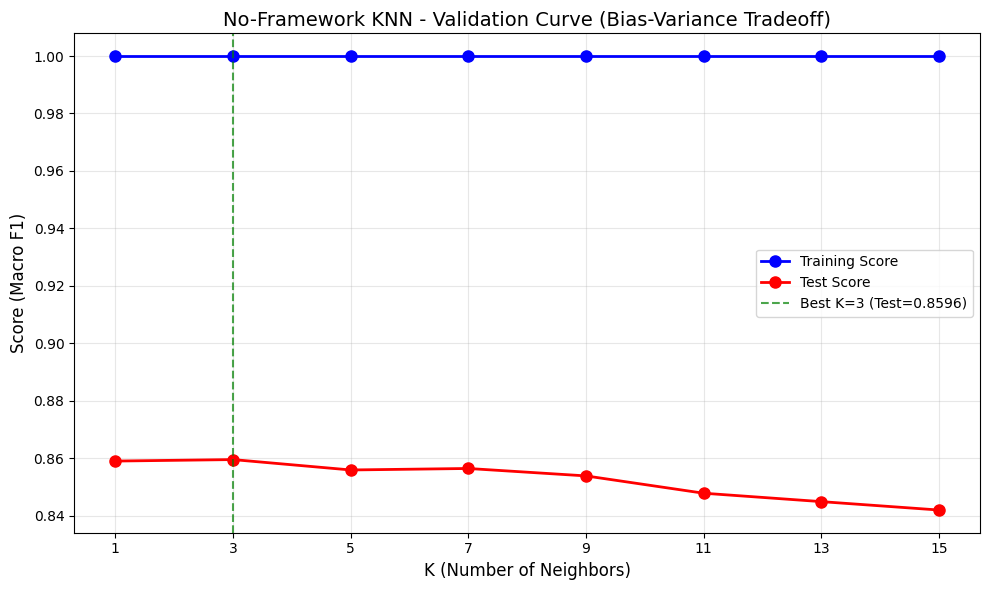

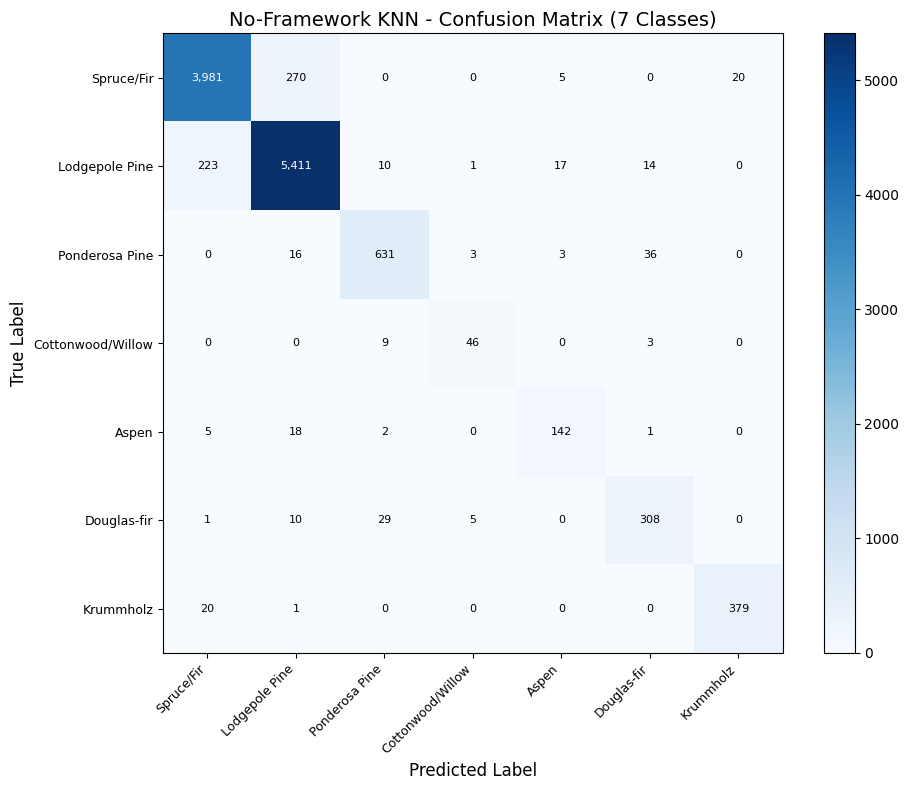

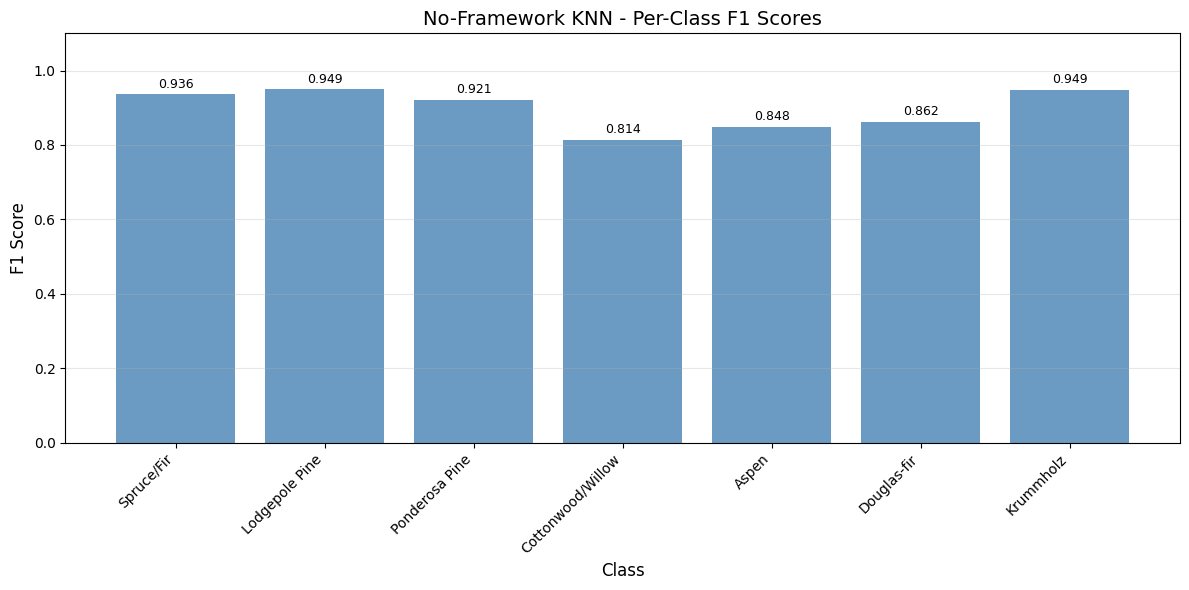

In [10]:
# Visualizations

# Validation Curve (K-Value Tuning)
plot_validation_curve(
    k_values=k_values,
    train_scores=train_scores,
    test_scores=test_scores,
    framework='No-Framework KNN',
    save_path='results/validation_curve.png'
)

# Confusion Matrix
plot_confusion_matrix_multiclass(
    y_true=y_eval,
    y_pred=y_pred,
    class_names=class_names,
    framework='No-Framework KNN',
    save_path='results/confusion_matrix.png'
)

# Per-Class F1 Scores
plot_per_class_f1(
    y_true=y_eval,
    y_pred=y_pred,
    class_names=class_names,
    framework='No-Framework KNN',
    save_path='results/per_class_f1.png'
)

## Summary

### Results
| Metric | No-Framework | Scikit-Learn |
|--------|--------------|--------------|
| Test Accuracy | 93.79% | 93.77% |
| Macro F1 Score | 0.8969 | 0.8935 |
| Prediction Time | ~2 hours (11.6K samples) | 57 seconds (116K samples) |
| Speed | ~1.5 pred/sec | ~2,000 pred/sec |

### Key Insights
- **Identical accuracy** proves our manual implementation is correct
- **1,300x slower** than Scikit-Learn due to:
  - No KD-tree optimization (brute force O(n) distance calculations)
  - Single-threaded Python loops vs multi-core C++ 
  - No SIMD vectorization
- **Educational value**: Understanding the algorithm deeply before using optimized libraries

In [11]:
# Save Final Results

import json

results = {
    'framework': 'No-Framework',
    'model': 'Manual KNN (Manhattan + Distance Weighting)',
    'best_k': best_k,
    'test_accuracy': float(test_acc),
    'macro_f1': float(macro_f1),
    'per_class_f1': {name: float(f1) for name, f1 in zip(class_names, per_class_f1)},
    'prediction_time_seconds': perf['time'],
    'test_samples': len(y_eval),
    'train_samples': len(X_train)
}

with open('results/metrics.json', 'w') as f:
    json.dump(results, f, indent=2)

print("Results saved to results/metrics.json")

Results saved to results/metrics.json
